In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [131]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [6]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [7]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [8]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [9]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [10]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [11]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

,Province,Pop
0,Gauteng,15176115
1,KwaZulu-Natal,11289086
2,Western Cape,6844272
3,Eastern Cape,6712276
4,Limpopo,5982584
5,Mpumalanga,4592187
6,Northwest,4027160
7,Free State,2887465
8,Northern Cape,1263875


In [12]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [13]:
province_pops.iloc[0]['Pop']

15176115

In [14]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# Download Data

## Download case data

In [15]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-03-05,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2020-03-07,20200307,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,NaN
2020-03-08,20200308,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN
2020-03-09,20200309,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN
2020-03-11,20200311,0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,20200805,80400.0,25232.0,185282.0,87798.0,9625.0,17135.0,5638.0,20686.0,98031.0,50.0,529877,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806,81014.0,26123.0,187631.0,90115.0,9873.0,17803.0,5932.0,21044.0,98599.0,50.0,538184,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807,81615.0,26877.0,189159.0,92444.0,10138.0,18266.0,6185.0,21315.0,99027.0,50.0,545476,https://twitter.com/nicd_sa/status/12918364670...


In [16]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-08-09 00:00:00'))

In [17]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-03',
               '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07',
               '2020-08-08', '2020-08-09'],
              dtype='datetime64[ns]', length=158, freq='D')

In [18]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
2020-03-05,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2020-03-06,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2020-03-07,20200307,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,NaN
2020-03-08,20200308,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN
2020-03-09,20200309,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,20200805,80400.0,25232.0,185282.0,87798.0,9625.0,17135.0,5638.0,20686.0,98031.0,50.0,529877,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806,81014.0,26123.0,187631.0,90115.0,9873.0,17803.0,5932.0,21044.0,98599.0,50.0,538184,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807,81615.0,26877.0,189159.0,92444.0,10138.0,18266.0,6185.0,21315.0,99027.0,50.0,545476,https://twitter.com/nicd_sa/status/12918364670...
2020-08-08,20200808,82074.0,27742.0,190999.0,95648.0,10345.0,18734.0,6366.0,21642.0,99588.0,50.0,553188,https://twitter.com/nicd_sa/status/12921773959...


In [19]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

,Date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
0,2020-03-05,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
1,2020-03-06,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2,2020-03-07,20200307,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,NaN
3,2020-03-08,20200308,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN
4,2020-03-09,20200309,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2020-08-05,20200805,80400.0,25232.0,185282.0,87798.0,9625.0,17135.0,5638.0,20686.0,98031.0,50.0,529877,https://twitter.com/nicd_sa/status/12911072678...
154,2020-08-06,20200806,81014.0,26123.0,187631.0,90115.0,9873.0,17803.0,5932.0,21044.0,98599.0,50.0,538184,https://twitter.com/nicd_sa/status/12914823911...
155,2020-08-07,20200807,81615.0,26877.0,189159.0,92444.0,10138.0,18266.0,6185.0,21315.0,99027.0,50.0,545476,https://twitter.com/nicd_sa/status/12918364670...
156,2020-08-08,20200808,82074.0,27742.0,190999.0,95648.0,10345.0,18734.0,6366.0,21642.0,99588.0,50.0,553188,https://twitter.com/nicd_sa/status/12921773959...


## Download death data

In [20]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-03-27,20200327,0,0,0,0,0,0,0,0,1,0,1,https://sacoronavirus.co.za/2020/03/27/latest-...
2020-03-28,20200328,0,0,0,1,0,0,0,0,1,0,2,NaN
2020-03-30,20200330,0,1,0,1,0,0,0,0,1,0,3,NaN
2020-03-31,20200331,0,1,1,2,0,0,0,0,1,0,5,NaN
2020-04-03,20200403,0,1,1,6,0,0,0,0,1,0,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,20200805,1967,327,2313,1038,90,139,36,109,3279,0,9298,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806,2033,350,2388,1116,90,139,54,109,3325,0,9604,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807,2090,350,2524,1192,90,139,61,109,3354,0,9909,https://twitter.com/nicd_sa/status/12918364670...


In [21]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
2020-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,20200805.0,1967.0,327.0,2313.0,1038.0,90.0,139.0,36.0,109.0,3279.0,0.0,9298.0,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806.0,2033.0,350.0,2388.0,1116.0,90.0,139.0,54.0,109.0,3325.0,0.0,9604.0,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807.0,2090.0,350.0,2524.0,1192.0,90.0,139.0,61.0,109.0,3354.0,0.0,9909.0,https://twitter.com/nicd_sa/status/12918364670...
2020-08-08,20200808.0,2129.0,350.0,2547.0,1346.0,127.0,139.0,66.0,130.0,3376.0,0.0,10210.0,https://twitter.com/nicd_sa/status/12921773959...


In [22]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,20200805.0,1967.0,327.0,2313.0,1038.0,90.0,139.0,36.0,109.0,3279.0,0.0,9298.0,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806.0,2033.0,350.0,2388.0,1116.0,90.0,139.0,54.0,109.0,3325.0,0.0,9604.0,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807.0,2090.0,350.0,2524.0,1192.0,90.0,139.0,61.0,109.0,3354.0,0.0,9909.0,https://twitter.com/nicd_sa/status/12918364670...
2020-08-08,20200808.0,2129.0,350.0,2547.0,1346.0,127.0,139.0,66.0,130.0,3376.0,0.0,10210.0,https://twitter.com/nicd_sa/status/12921773959...


In [23]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

,Date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
0,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2020-08-05,20200805.0,1967.0,327.0,2313.0,1038.0,90.0,139.0,36.0,109.0,3279.0,0.0,9298.0,https://twitter.com/nicd_sa/status/12911072678...
154,2020-08-06,20200806.0,2033.0,350.0,2388.0,1116.0,90.0,139.0,54.0,109.0,3325.0,0.0,9604.0,https://twitter.com/nicd_sa/status/12914823911...
155,2020-08-07,20200807.0,2090.0,350.0,2524.0,1192.0,90.0,139.0,61.0,109.0,3354.0,0.0,9909.0,https://twitter.com/nicd_sa/status/12918364670...
156,2020-08-08,20200808.0,2129.0,350.0,2547.0,1346.0,127.0,139.0,66.0,130.0,3376.0,0.0,10210.0,https://twitter.com/nicd_sa/status/12921773959...


## Download recovery data

In [24]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-04-17,20200417,9,71,479,96,18,9,10,6,205,0,903,https://twitter.com/nicd_sa/status/12512151947...
2020-04-18,20200418,9,71,479,96,18,9,10,6,205,0,903,https://twitter.com/nicd_sa/status/12515952235...
2020-04-19,20200419,9,71,479,96,18,9,10,6,205,0,903,https://twitter.com/nicd_sa/status/12519270552...
2020-04-20,20200420,15,74,545,151,21,14,13,6,216,0,1055,https://twitter.com/nicd_sa/status/12523098244...
2020-04-21,20200421,15,74,545,151,21,14,13,6,216,0,1055,https://twitter.com/nicd_sa/status/12526435556...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,20200805,72570,10582,129375,51857,5620,11632,2859,9243,83528,0,377266,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806,74004,11575,132002,53444,6876,12290,3069,9527,84529,0,387316,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807,74936,11832,135485,53509,6876,13322,3089,10182,85528,0,394759,https://twitter.com/nicd_sa/status/12918364670...


In [25]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
2020-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,20200805.0,72570.0,10582.0,129375.0,51857.0,5620.0,11632.0,2859.0,9243.0,83528.0,0.0,377266.0,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806.0,74004.0,11575.0,132002.0,53444.0,6876.0,12290.0,3069.0,9527.0,84529.0,0.0,387316.0,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807.0,74936.0,11832.0,135485.0,53509.0,6876.0,13322.0,3089.0,10182.0,85528.0,0.0,394759.0,https://twitter.com/nicd_sa/status/12918364670...
2020-08-08,20200808.0,74941.0,12155.0,139745.0,54161.0,7813.0,14257.0,3158.0,11923.0,86415.0,0.0,404568.0,https://twitter.com/nicd_sa/status/12921773959...


In [26]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,20200805.0,72570.0,10582.0,129375.0,51857.0,5620.0,11632.0,2859.0,9243.0,83528.0,0.0,377266.0,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806.0,74004.0,11575.0,132002.0,53444.0,6876.0,12290.0,3069.0,9527.0,84529.0,0.0,387316.0,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807.0,74936.0,11832.0,135485.0,53509.0,6876.0,13322.0,3089.0,10182.0,85528.0,0.0,394759.0,https://twitter.com/nicd_sa/status/12918364670...
2020-08-08,20200808.0,74941.0,12155.0,139745.0,54161.0,7813.0,14257.0,3158.0,11923.0,86415.0,0.0,404568.0,https://twitter.com/nicd_sa/status/12921773959...


In [27]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

,Date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
0,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2020-08-05,20200805.0,72570.0,10582.0,129375.0,51857.0,5620.0,11632.0,2859.0,9243.0,83528.0,0.0,377266.0,https://twitter.com/nicd_sa/status/12911072678...
154,2020-08-06,20200806.0,74004.0,11575.0,132002.0,53444.0,6876.0,12290.0,3069.0,9527.0,84529.0,0.0,387316.0,https://twitter.com/nicd_sa/status/12914823911...
155,2020-08-07,20200807.0,74936.0,11832.0,135485.0,53509.0,6876.0,13322.0,3089.0,10182.0,85528.0,0.0,394759.0,https://twitter.com/nicd_sa/status/12918364670...
156,2020-08-08,20200808.0,74941.0,12155.0,139745.0,54161.0,7813.0,14257.0,3158.0,11923.0,86415.0,0.0,404568.0,https://twitter.com/nicd_sa/status/12921773959...


## Download testing data
Only for country

In [28]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-08-05    3113191.0
2020-08-06    3149807.0
2020-08-07    3183658.0
2020-08-08    3220265.0
2020-08-09    3250583.0
Name: cumulative_tests, Length: 163, dtype: float64

In [29]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-08-05    3113191.0
2020-08-06    3149807.0
2020-08-07    3183658.0
2020-08-08    3220265.0
2020-08-09    3250583.0
Freq: D, Name: cumulative_tests, Length: 158, dtype: float64

In [30]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-08-05    3113191.0
2020-08-06    3149807.0
2020-08-07    3183658.0
2020-08-08    3220265.0
2020-08-09    3250583.0
Freq: D, Name: Total RSA, Length: 158, dtype: float64

In [31]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

,Date,Total RSA
0,2020-03-05,164.0
1,2020-03-06,200.0
2,2020-03-07,241.0
3,2020-03-08,241.0
4,2020-03-09,241.0
...,...,...
153,2020-08-05,3113191.0
154,2020-08-06,3149807.0
155,2020-08-07,3183658.0
156,2020-08-08,3220265.0


# Analysis Per Province

In [32]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [33]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [34]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

,Total RSA,EC,FS,GP,KZN,LP,MP,NC,NW,WC
Date,,,,,,,,,,
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-08-05,386564.0,74537.0,10909.0,131688.0,52895.0,5710.0,11771.0,2895.0,9352.0,86807.0
2020-08-06,396920.0,76037.0,11925.0,134390.0,54560.0,6966.0,12429.0,3123.0,9636.0,87854.0
2020-08-07,404668.0,77026.0,12182.0,138009.0,54701.0,6966.0,13461.0,3150.0,10291.0,88882.0


In [35]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

,Date,Total RSA,EC,FS,GP,KZN,LP,MP,NC,NW,WC
0,2020-03-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,2020-03-06,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,2020-03-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,2020-03-08,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,2020-03-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
153,2020-08-05,-386564.0,-74537.0,-10909.0,-131688.0,-52895.0,-5710.0,-11771.0,-2895.0,-9352.0,-86807.0
154,2020-08-06,-396920.0,-76037.0,-11925.0,-134390.0,-54560.0,-6966.0,-12429.0,-3123.0,-9636.0,-87854.0
155,2020-08-07,-404668.0,-77026.0,-12182.0,-138009.0,-54701.0,-6966.0,-13461.0,-3150.0,-10291.0,-88882.0
156,2020-08-08,-414778.0,-77070.0,-12505.0,-142292.0,-55507.0,-7940.0,-14396.0,-3224.0,-12053.0,-89791.0


In [36]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

,Date,Total RSA,EC,FS,GP,KZN,LP,MP,NC,NW,WC
0,2020-03-05,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-06,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-07,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-08,3.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-09,7.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
153,2020-08-05,143313.0,5863.0,14323.0,53594.0,34903.0,3915.0,5364.0,2743.0,11334.0,11224.0
154,2020-08-06,141264.0,4977.0,14198.0,53241.0,35555.0,2907.0,5374.0,2809.0,11408.0,10745.0
155,2020-08-07,140808.0,4589.0,14695.0,51150.0,37743.0,3172.0,4805.0,3035.0,11024.0,10145.0
156,2020-08-08,138410.0,5004.0,15237.0,48707.0,40141.0,2405.0,4338.0,3142.0,9589.0,9797.0


In [37]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [38]:
analysis_all = pd.concat([analysis_cases, analysis_active, analysis_recovery, analysis_deaths])
analysis_all

,Date,Province,Value,Data
0,2020-03-05,Total RSA,1.0,Cases
1,2020-03-06,Total RSA,1.0,Cases
2,2020-03-07,Total RSA,2.0,Cases
3,2020-03-08,Total RSA,3.0,Cases
4,2020-03-09,Total RSA,7.0,Cases
...,...,...,...,...
1575,2020-08-05,WC,3279.0,Deaths
1576,2020-08-06,WC,3325.0,Deaths
1577,2020-08-07,WC,3354.0,Deaths
1578,2020-08-08,WC,3376.0,Deaths


In [40]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [44]:
template_h = '%{y}'

## Plot analysis for provinces

In [45]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x")
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [46]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [ ]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [48]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [49]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

,Date,Province,Value,Data
0,2020-03-05,Total RSA,1.0,Cases
1,2020-03-06,Total RSA,1.0,Cases
2,2020-03-07,Total RSA,2.0,Cases
3,2020-03-08,Total RSA,3.0,Cases
4,2020-03-09,Total RSA,7.0,Cases
...,...,...,...,...
153,2020-08-05,Total RSA,3113191.0,Tests
154,2020-08-06,Total RSA,3149807.0,Tests
155,2020-08-07,Total RSA,3183658.0,Tests
156,2020-08-08,Total RSA,3220265.0,Tests


In [50]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data', line_shape='spline')
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [51]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [ ]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")

In [125]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

,Date,Province,Value,Data
157,2020-08-09,Total RSA,559858.0,Cases
157,2020-08-09,Total RSA,138303.0,Active
157,2020-08-09,Total RSA,411147.0,Recovered
157,2020-08-09,Total RSA,10408.0,Deaths
157,2020-08-09,Total RSA,3250583.0,Tests


In [132]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [133]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('559,858', 138303.0, 411147.0, 10408.0, 3250583.0)

## Plot analysis per province

In [52]:
max_states = max(analysis_states['Value']) * 1.05
max_states

202405.35

In [53]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [54]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [55]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

,Date,Province,Value,Data
0,2020-03-06,Total RSA,0.0,Active
1,2020-03-07,Total RSA,1.0,Active
2,2020-03-08,Total RSA,1.0,Active
3,2020-03-09,Total RSA,4.0,Active
4,2020-03-10,Total RSA,0.0,Active
...,...,...,...,...
1565,2020-08-05,WC,-345.0,Active
1566,2020-08-06,WC,-479.0,Active
1567,2020-08-07,WC,-600.0,Active
1568,2020-08-08,WC,-348.0,Active


In [56]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

,Total RSA,EC,FS,GP,KZN,LP,MP,NC,NW,WC
2020-03-06,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-10,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-08-05,7060.0,459.0,778.0,1824.0,2133.0,215.0,656.0,207.0,282.0,482.0
2020-08-06,7258.0,477.0,790.0,1831.0,2238.0,226.0,661.0,225.0,294.0,492.0
2020-08-07,7463.0,497.0,798.0,1859.0,2393.0,230.0,636.0,234.0,299.0,506.0
2020-08-08,7535.0,495.0,789.0,1863.0,2540.0,229.0,592.0,241.0,295.0,503.0


In [57]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

,Date,Province,Value,Data
0,2020-03-06,Total RSA,1.0,Cases Smoothed
1,2020-03-07,Total RSA,1.0,Cases Smoothed
2,2020-03-08,Total RSA,2.0,Cases Smoothed
3,2020-03-09,Total RSA,2.0,Cases Smoothed
4,2020-03-10,Total RSA,3.0,Cases Smoothed
...,...,...,...,...
1565,2020-08-05,WC,482.0,Cases Smoothed
1566,2020-08-06,WC,492.0,Cases Smoothed
1567,2020-08-07,WC,506.0,Cases Smoothed
1568,2020-08-08,WC,503.0,Cases Smoothed


In [58]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [59]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

,Date,Province,Value,Data
0,2020-03-06,Total RSA,0.0,Cases
1,2020-03-07,Total RSA,1.0,Cases
2,2020-03-08,Total RSA,1.0,Cases
3,2020-03-09,Total RSA,4.0,Cases
4,2020-03-10,Total RSA,0.0,Cases
...,...,...,...,...
152,2020-08-05,Total RSA,414.0,Deaths
153,2020-08-06,Total RSA,306.0,Deaths
154,2020-08-07,Total RSA,305.0,Deaths
155,2020-08-08,Total RSA,301.0,Deaths


In [60]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

,Date,Province,Value,Data
0,2020-03-06,Total RSA,36.0,Tests
1,2020-03-07,Total RSA,41.0,Tests
2,2020-03-08,Total RSA,0.0,Tests
3,2020-03-09,Total RSA,0.0,Tests
4,2020-03-10,Total RSA,0.0,Tests
...,...,...,...,...
152,2020-08-05,Total RSA,34989.0,Tests
153,2020-08-06,Total RSA,36616.0,Tests
154,2020-08-07,Total RSA,33851.0,Tests
155,2020-08-08,Total RSA,36607.0,Tests


In [61]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

,Date,Province,Value,Data
0,2020-03-06,Total RSA,0.0,Cases
1,2020-03-07,Total RSA,1.0,Cases
2,2020-03-08,Total RSA,1.0,Cases
3,2020-03-09,Total RSA,4.0,Cases
4,2020-03-10,Total RSA,0.0,Cases
...,...,...,...,...
152,2020-08-05,Total RSA,34989.0,Tests
153,2020-08-06,Total RSA,36616.0,Tests
154,2020-08-07,Total RSA,33851.0,Tests
155,2020-08-08,Total RSA,36607.0,Tests


## Plot daily change for South Africa

In [62]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data', line_shape='spline')
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [63]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [64]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(11511.15, -7221.900000000001)

In [65]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF")
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [66]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [67]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

,date,Ekurhuleni\tCases,Johannesburg\tCases,Sedibeng\tCases,Tshwane\tCases,West Rand\tCases,GP Unallocated\tCases,Total
115,2020-08-04,40863.0,74962.0,12056.0,37554.0,11902.0,NaN,177337.0
116,2020-08-05,41393.0,75654.0,12210.0,38023.0,12028.0,5974.0,185282.0
117,2020-08-06,41895.0,76297.0,12440.0,38814.0,12155.0,6030.0,187631.0
118,2020-08-07,42304.0,76763.0,12541.0,39286.0,12217.0,6048.0,189159.0
119,2020-08-08,42718.0,77420.0,12688.0,39813.0,12309.0,6051.0,190999.0


# Rt Model 1

## Data Import

In [68]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-08-05  1.01     1.13    0.86
          2020-08-06  1.18     1.30    1.04
          2020-08-07  1.19     1.31    1.05
          2020-08-08  1.08     1.19    0.93
          2020-08-09  0.82     0.94    0.68

[1020 rows x 3 columns]

In [69]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

,Province,Date,Rt,High_90,Low_90
0,EC,2020-04-11,3.84,6.35,0.79
1,EC,2020-04-12,3.35,5.13,1.25
2,EC,2020-04-13,3.12,4.54,1.56
3,EC,2020-04-14,2.72,3.88,1.41
4,EC,2020-04-15,2.27,3.29,1.12
...,...,...,...,...,...
1015,Total RSA,2020-08-05,1.01,1.13,0.86
1016,Total RSA,2020-08-06,1.18,1.30,1.04
1017,Total RSA,2020-08-07,1.19,1.31,1.05
1018,Total RSA,2020-08-08,1.08,1.19,0.93


## Setup Rt

In [70]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

,Province,Date,Rt,High_90,Low_90
876,Total RSA,2020-03-19,2.11,3.70,0.22
877,Total RSA,2020-03-20,2.50,3.73,1.09
878,Total RSA,2020-03-21,2.75,3.71,1.67
879,Total RSA,2020-03-22,2.87,3.67,1.99
880,Total RSA,2020-03-23,2.97,3.64,2.20
...,...,...,...,...,...
1015,Total RSA,2020-08-05,1.01,1.13,0.86
1016,Total RSA,2020-08-06,1.18,1.30,1.04
1017,Total RSA,2020-08-07,1.19,1.31,1.05
1018,Total RSA,2020-08-08,1.08,1.19,0.93


In [71]:
X0rt1 = state_single.iloc[1]['Date']
X0rt1

Timestamp('2020-03-20 00:00:00')

In [72]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('09 August 2020', 0.82)

## Latest Rt summary

In [73]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

,ML
state,
EC,0.78
FS,0.85
GP,0.86
KZN,1.29
LP,0.92
MP,0.33
NC,1.10
NW,0.78
Total RSA,0.82


In [74]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [75]:
state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [76]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [77]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

,Province,Date,Rt,High_90,Low_90
0,EC,2020-04-11,3.84,6.35,0.79
1,EC,2020-04-12,3.35,5.13,1.25
2,EC,2020-04-13,3.12,4.54,1.56
3,EC,2020-04-14,2.72,3.88,1.41
4,EC,2020-04-15,2.27,3.29,1.12
...,...,...,...,...,...
871,WC,2020-08-05,0.59,0.92,0.20
872,WC,2020-08-06,0.85,1.20,0.48
873,WC,2020-08-07,1.01,1.36,0.65
874,WC,2020-08-08,0.99,1.31,0.60


In [78]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [79]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [80]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [81]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [82]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

,Date,Rt,High_80,Low_80,Infections,Adjusted_Postive
0,2020-02-26,1.921,2.188,1.604,192.469,0.000
1,2020-02-27,1.915,2.161,1.595,2.642,0.000
2,2020-02-28,1.916,2.139,1.596,37.460,0.000
3,2020-02-29,1.896,2.149,1.625,71.349,0.000
4,2020-03-01,1.892,2.097,1.600,79.129,0.000
...,...,...,...,...,...,...
160,2020-08-04,0.942,1.134,0.770,6416.942,8327.351
161,2020-08-05,0.937,1.129,0.761,6382.448,8246.323
162,2020-08-06,0.941,1.099,0.724,6351.407,8167.556
163,2020-08-07,0.937,1.128,0.750,6325.183,8091.525


In [83]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [84]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = round(latest_rt2['Rt'], 2)
rt2

0.93

In [85]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-08-08 00:00:00'), '08 August 2020')

In [86]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [87]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [88]:
Pc = 1-(1/rt2)
Pc * 100

-7.526881720430101

In [89]:
immune = country_pop * Pc
immune

-4423926.236559136

## Rt trends model

In [90]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

,Date,Cases
0,2020-03-05,1
1,2020-03-06,1
2,2020-03-07,2
3,2020-03-08,3
4,2020-03-09,7
...,...,...
153,2020-08-05,529877
154,2020-08-06,538184
155,2020-08-07,545476
156,2020-08-08,553188


In [91]:
from datetime import timedelta, date

In [92]:
f = 60

In [93]:
f2 = 30

In [94]:
diff = cases_df['Cases'].diff()

In [95]:
d = diff.values[-1]
d

6670.0

In [96]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
    r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.3,
 1.25,
 1.2,
 1.15,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.93,
 0.925,
 0.9,
 0.85,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [97]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

,Date,Cases,R
0,2020-03-05,1.000000,1.5
1,2020-03-06,1.000000,1.5
2,2020-03-07,2.000000,1.5
3,2020-03-08,3.000000,1.5
4,2020-03-09,7.000000,1.5
...,...,...,...
0,2020-10-04,560599.111111,0.1
0,2020-10-05,560599.111111,0.1
0,2020-10-06,560599.111111,0.1
0,2020-10-07,560599.111111,0.1


In [98]:
current_forecast = future_projections.query(f"R == {rt2}")
current_forecast

,Date,Cases,R
0,2020-03-05,1.000000,0.93
1,2020-03-06,1.000000,0.93
2,2020-03-07,2.000000,0.93
3,2020-03-08,3.000000,0.93
4,2020-03-09,7.000000,0.93
...,...,...,...
0,2020-10-04,646951.219333,0.93
0,2020-10-05,647057.793980,0.93
0,2020-10-06,647156.908401,0.93
0,2020-10-07,647249.084813,0.93


In [99]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

647334

In [100]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.1%'

In [101]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [102]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

679701.5493201577

In [103]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [104]:
increasing_forecast = future_projections.query(f"R > 1")

In [105]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [106]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [107]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [108]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [109]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [110]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-08-05  1.01     1.13    0.86
          2020-08-06  1.18     1.30    1.04
          2020-08-07  1.19     1.31    1.05
          2020-08-08  1.08     1.19    0.93
          2020-08-09  0.82     0.94    0.68

[1020 rows x 3 columns]

In [111]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [112]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

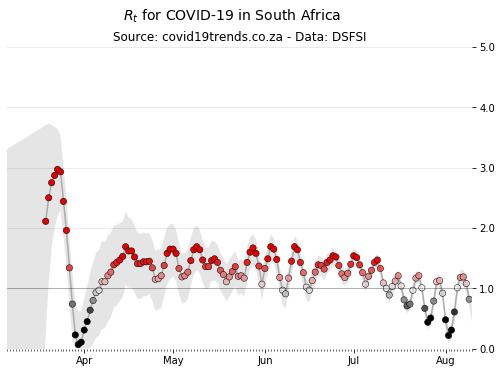

In [113]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [114]:
states_rt_i = states_all_rt_i.loc[state_filter]

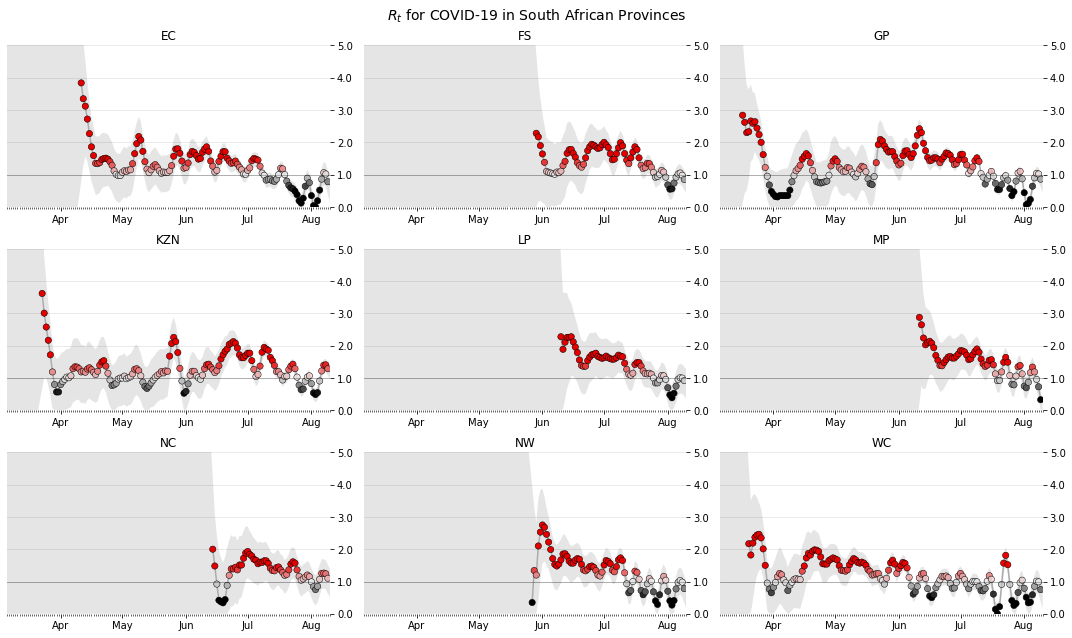

In [115]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [116]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [117]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

,ML,High_90,Low_90
state,,,
EC,0.78,1.11,0.39
FS,0.85,1.14,0.53
GP,0.86,1.06,0.61
KZN,1.29,1.47,1.08
LP,0.92,1.35,0.44
MP,0.33,0.60,0.00
NC,1.10,1.52,0.63
NW,0.78,1.18,0.34
Total RSA,0.82,0.94,0.68


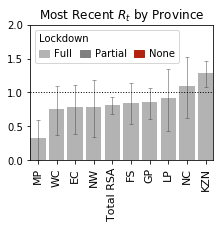

In [118]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

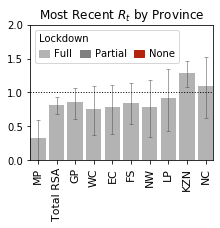

In [119]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

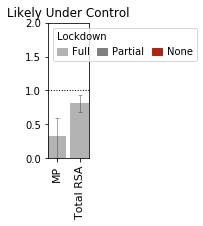

In [120]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

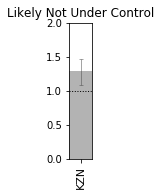

In [121]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()